In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import jax.numpy as jnp
import xgboost as xgb
import jax
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import anndata

/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/scanpy/_utils/__init__.py:27: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/scanpy/__init__.py:36: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [3]:
def get_pert_vectors(adata, cell_line_key = 'cell_name', drug_key = 'drugname_drugconc', control_treatment ="[('DMSO_TF', 0.0, 'uM')]" ):
    # Extract metadata and group labels
    meta_df = adata.obs[[cell_line_key, drug_key ]].copy()
    meta_df['group'] = meta_df[cell_line_key].astype(str) + '|' + meta_df[drug_key].astype(str)
    # Map groups to integer indices
   
    group_idx, unique_groups = pd.factorize(meta_df['group'])
    # Then run your code
    # Extract metadata and group labels
    meta_df = adata.obs[[cell_line_key,  drug_key ]].copy()
    meta_df['group'] = meta_df[cell_line_key].astype(str) + '|' + meta_df[drug_key ].astype(str)
    adata.obs['group'] = adata.obs[cell_line_key].astype(str) + '|' + adata.obs[drug_key ].astype(str)
    print('here')
    # Map groups to integer indices
    group_idx, unique_groups = pd.factorize(meta_df['group'])
    # X_jax: (n_cells, n_dims)
    # group_idx: int array of length n_cells (e.g., from pd.factorize)
    X_jax = jnp.array(adata.X.astype('float32'))
    print('here')
    group_idx = jnp.array(group_idx)
    n_groups = len(unique_groups)
    sums = jax.ops.segment_sum(X_jax, group_idx, n_groups)
    counts = jax.ops.segment_sum(jnp.ones((X_jax.shape[0], 1)), group_idx, n_groups)
    centroids = sums / counts
    # Back to Pandas to identify DMSO indices
    group_labels = pd.Series(unique_groups)
    cell_types = group_labels.str.split('|').str[0]
    perts = group_labels.str.split('|').str[1]

    # Find the index of each DMSO centroid by cell_type
    dmso_idx = (perts == control_treatment)

    # Convert boolean mask to indices for JAX
    dmso_indices = np.where(dmso_idx.values)[0]  # Convert pandas boolean to JAX indices
    dmso_centroids = centroids[dmso_indices]

    # Match non-DMSO centroids to their corresponding DMSO by cell_type
    pert_indices = np.where(~dmso_idx.values)[0]  # Also convert this to JAX indices
    pert_cell_types = cell_types[~dmso_idx].values

    # Build a lookup: cell_type → index in dmso_centroids
    dmso_cell_types = cell_types[dmso_idx].values
    dmso_cell_type_to_idx = dict(zip(dmso_cell_types, dmso_indices))

    # Get DMSO centroid for each perturbation group
    dmso_for_pert = np.stack([
        centroids[dmso_cell_type_to_idx[ct]] for ct in pert_cell_types
    ])

    # Compute perturbation vectors
    pert_vectors = centroids[pert_indices] - dmso_for_pert
    reference_df = pd.DataFrame({
    'variable': cell_types,
    'drug': perts,
    'order': range(len(cell_types))
    })
    return pert_vectors, reference_df

In [14]:
a549_ground_truth = sc.read_h5ad('/large_storage/ctc/userspace/aadduri/revisions/A549_holdout_se/eval_last.ckpt/adata_real.h5ad')
a549_ground_truth = anndata.AnnData(X = a549_ground_truth.obsm['X_state'], obs = a549_ground_truth.obs)
real_vectors, ref_real = get_pert_vectors(a549_ground_truth)
ref_real= ref_real[ref_real['drug'] != "[('DMSO_TF', 0.0, 'uM')]" ]
del a549_ground_truth

here
here


In [15]:
a549_pred = sc.read_h5ad('/large_storage/ctc/userspace/aadduri/revisions/A549_holdout_se/eval_last.ckpt/adata_pred.h5ad')
a549_pred = anndata.AnnData(X = a549_pred.obsm['X_state'], obs = a549_pred.obs)
pred_vectors, ref_pred = get_pert_vectors(a549_pred)
ref_pred= ref_pred[ref_pred['drug'] != "[('DMSO_TF', 0.0, 'uM')]" ]
del a549_pred

here
here


In [10]:
myllia.obs['sgrna_symbol'].unique()

['non-targeting', 'LCP2', 'BCOR', 'HDAC1', 'PPARG', ..., 'UTP6', 'DHX36', 'UBA3', 'DHDDS', 'SEC61A1']
Length: 220
Categories (220, object): ['ADGRV1', 'AK9', 'AMOTL2', 'ANKIB1', ..., 'XRRA1', 'ZNF598', 'gene_desert', 'non-targeting']

In [32]:
myllia = sc.read_h5ad('/large_storage/ctc/userspace/aadduri/myllia_se.h5ad')
myllia = myllia[myllia.obs['cl'] == 'A549']
myllia  = anndata.AnnData(X = myllia.obsm['X_state'], obs = myllia.obs)
myllia.obs['sgrna_symbol'] = myllia.obs['sgrna_symbol'].astype(str)
myllia.obs.loc[myllia.obs['sgrna_symbol'].isin(['non-targeting', 'gene_desert']), 'sgrna_symbol'] = 'control'
myllia_vectors, ref_myllia  = get_pert_vectors(myllia, cell_line_key='cl', drug_key='sgrna_symbol', control_treatment='control')
ref_myllia = ref_myllia[ref_myllia['drug'] != 'control']
del myllia

/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/anndata/_core/anndata.py:1792: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/anndata/_core/anndata.py:1792: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


here
here


In [33]:
from scipy.spatial.distance import cdist

In [46]:
pred_distances = cdist(myllia_vectors, pred_vectors)
real_distances = cdist(myllia_vectors, real_vectors)
pred_distances = pd.DataFrame(pred_distances)
real_distances = pd.DataFrame(real_distances)

In [62]:
pred_distances.columns = ref_pred['drug']
pred_distances.index = ref_myllia['drug']
real_distances.index = ref_myllia['drug']
real_distances.columns = ref_pred['drug']

In [63]:
pred_distances = pred_distances.div(pred_distances.sum(axis = 1), axis = 0)
real_distances = real_distances.div(real_distances.sum(axis = 1), axis = 0)

In [84]:
pred_distances.sum(axis = 1).sort_values()

drug
KDM8       1.0
CDK8       1.0
SMARCA5    1.0
DHDDS      1.0
DHX36      1.0
          ... 
ERBB2      1.0
PHF3       1.0
ATXN7L3    1.0
KDM5A      1.0
FOSL1      1.0
Length: 218, dtype: float64

In [65]:
pred_distances["[('Trametinib', 5.0, 'uM')]"].sort_values()

drug
SHOC2     0.000678
PTPN11    0.000722
RAF1      0.000758
LDB1      0.000759
EGFR      0.000772
            ...   
UBA5      0.000913
NF2       0.000915
SIRT1     0.000920
EHMT1     0.000932
CBX3      0.000939
Name: [('Trametinib', 5.0, 'uM')], Length: 218, dtype: float64

In [66]:
real_distances["[('Trametinib', 5.0, 'uM')]"].sort_values()

drug
PTPN11    0.000760
SHOC2     0.000787
DDX1      0.000843
RAF1      0.000854
BMS1      0.000854
            ...   
SIRT1     0.001013
BMPR1A    0.001015
CD3G      0.001016
CBX3      0.001031
ARL1      0.001034
Name: [('Trametinib', 5.0, 'uM')], Length: 218, dtype: float64

In [67]:
genes

RangeIndex(start=0, stop=218, step=1)

In [68]:
real_distances.shape

(218, 1137)

In [69]:
real_distances.index

Index(['LCP2', 'BCOR', 'HDAC1', 'PPARG', 'CBFB', 'PTEN', 'SMAD4', 'MAPK14',
       'PDIA6', 'LPAR5',
       ...
       'TFAM', 'RRP9', 'CTCF', 'DOT1L', 'BMS1', 'UTP6', 'DHX36', 'UBA3',
       'DHDDS', 'SEC61A1'],
      dtype='object', name='drug', length=218)

In [85]:
pred_distances["[('Tucidinostat', 5.0, 'uM')]"].sort_values()

drug
KDM1A     0.000755
KDM3B     0.000789
PRORP     0.000790
SRFBP1    0.000795
VRK1      0.000799
            ...   
EHMT1     0.000900
RNF146    0.000903
CBX3      0.000905
NFIB      0.000906
CREBBP    0.000910
Name: [('Tucidinostat', 5.0, 'uM')], Length: 218, dtype: float64

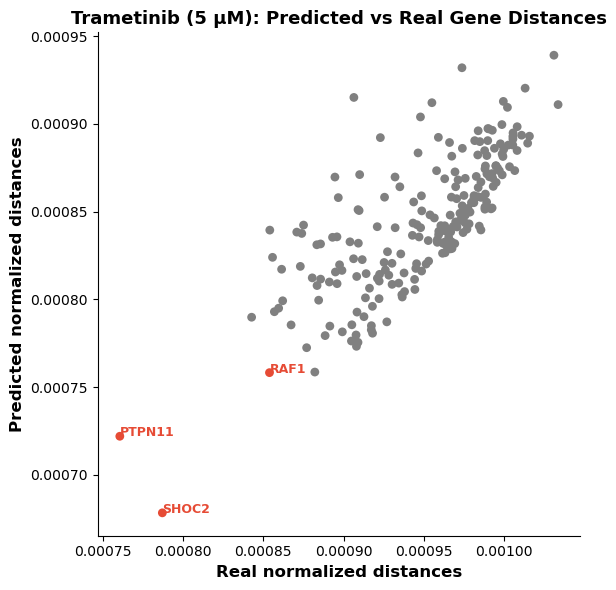

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Build rank-based dataframe ---
genes = real_distances.index
real_vals = real_distances["[('Trametinib', 5.0, 'uM')]"]
pred_vals = pred_distances["[('Trametinib', 5.0, 'uM')]"]

df_plot = pd.DataFrame({
    "gene": genes,
    "real_rank": real_vals,   # rank 1 = largest distance
    "pred_rank": pred_vals
})

highlight_genes = ['PTPN11', 'RAF1', 'SHOC2']
df_plot["highlight"] = df_plot["gene"].isin(highlight_genes)

# --- Plot ---
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_plot,
    x="real_rank", y="pred_rank",
    hue="highlight",
    palette={True: "#E64B35FF", False: "grey"},
    s=40, edgecolor="none"
)

# Label the highlighted genes
texts = []
for gene in highlight_genes:
    if gene in df_plot.index:
        x = df_plot.loc[gene, 'real_rank']
        y = df_plot.loc[gene, 'pred_rank']


        texts.append(plt.text(x, y, gene,
                                    fontsize=9, weight='bold', color='#E64B35FF'))




# Axis labels and styling
plt.xlabel("Real normalized distances", fontsize=12, weight='bold')
plt.ylabel("Predicted normalized distances", fontsize=12, weight='bold')
plt.title("Trametinib (5 µM): Predicted vs Real Gene Distances", fontsize=13, weight='bold')
plt.grid(False)
sns.despine()
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig('Trametibib correlations.png')
plt.savefig('Trametibib correlations.pdf')
plt.show()

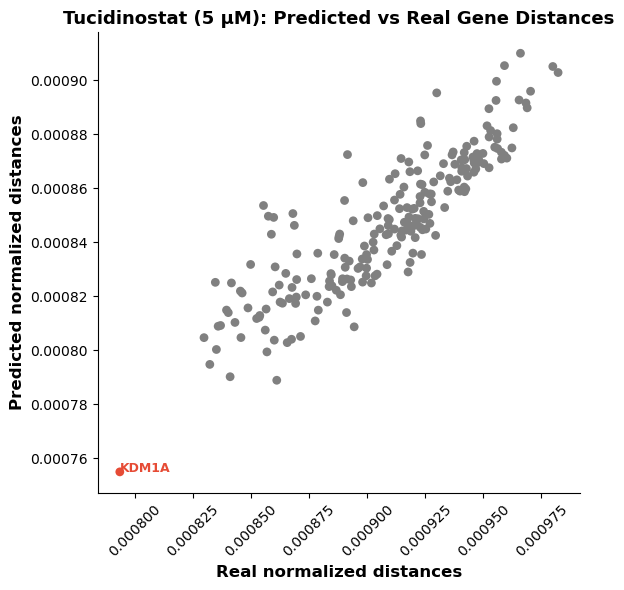

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Build rank-based dataframe ---
genes = real_distances.index
real_vals = real_distances["[('Tucidinostat', 5.0, 'uM')]"]
pred_vals = pred_distances["[('Tucidinostat', 5.0, 'uM')]"]

df_plot = pd.DataFrame({
    "gene": genes,
    "real_rank": real_vals,   # rank 1 = largest distance
    "pred_rank": pred_vals
})

highlight_genes = ['KDM1A']
df_plot["highlight"] = df_plot["gene"].isin(highlight_genes)

# --- Plot ---
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_plot,
    x="real_rank", y="pred_rank",
    hue="highlight",
    palette={True: "#E64B35FF", False: "grey"},
    s=40, edgecolor="none"
)

# Label the highlighted genes
texts = []
for gene in highlight_genes:
    if gene in df_plot.index:
        x = df_plot.loc[gene, 'real_rank']
        y = df_plot.loc[gene, 'pred_rank']


        texts.append(plt.text(x, y, gene,
                                    fontsize=9, weight='bold', color='#E64B35FF'))




# Axis labels and styling
plt.xlabel("Real normalized distances", fontsize=12, weight='bold')
plt.ylabel("Predicted normalized distances", fontsize=12, weight='bold')
plt.title("Tucidinostat (5 µM): Predicted vs Real Gene Distances", fontsize=13, weight='bold')
plt.grid(False)
sns.despine()
plt.xticks(rotation = 45)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig('Tucidinostat correlations.png')
plt.savefig('Tucidinostat correlations.pdf')
plt.show()

In [87]:
from scipy import stats
r_vals, p_vals = [], []
for target in real_distances.columns:
    r, p = stats.pearsonr(real_distances[target], pred_distances[target])
    r_vals.append(r)
    p_vals.append(p)

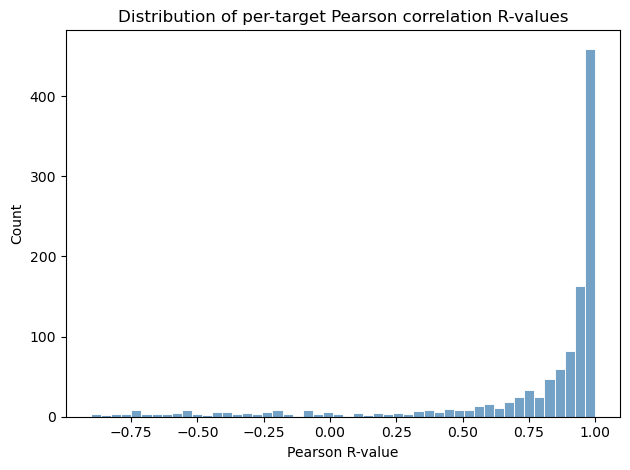

In [88]:
sns.histplot(r_vals, bins=50, color='steelblue', edgecolor='white')
plt.xlabel('Pearson R-value')
plt.ylabel('Count')
plt.title('Distribution of per-target Pearson correlation R-values')
plt.tight_layout()
plt.savefig('pearson_r_distribution.pdf')
plt.savefig('pearson_r_distribution.png')
plt.show()